## 3. Preprocessing and Modelling

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import cleaned file

df = pd.read_csv("data/reddit_df_clean.csv")

In [3]:
# double check for null, or else it will throw an error when fitting
df.isnull().sum()

text         0
subreddit    0
dtype: int64

In [4]:
# set X and Y
X = df['text']
y = df['subreddit']

In [5]:
# split into train-test set, stratified by y

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y,
                                                    test_size= 0.3333)

### Setting Baseline Score

The baseline score will be the using Logistic Regression with Count Vectorisation, albeit without any parameters. The ideal models should not be performing worse than this.

In [6]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

In [7]:
# check cross validation score to see how well it generalise to unseen data
cross_val_score(pipe, X_train, y_train, cv=3).mean()

0.6430646757697343

In [8]:
cross_val_score(pipe, X_test, y_test, cv=3).mean()

0.6098310291858678

We can expect the model to generalise quite well to unseen data with accuracy of around 60-65%.

In [9]:
# fit the model
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('logreg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                       

**Establish Baseline Score**

In [10]:
# baseline training score
pipe.score(X_train, y_train)

0.9738461538461538

In [11]:
# baseline test score
pipe.score(X_test, y_test)

0.6328725038402457

Based on a vanilla model of Logistic Regression with Count Vectoriser, with no parameters, the model has an accuracy of 63.29% in predicting unseen data. It is also highly overfitted with an accuracy of 97.38% on the training set. These are the baseline scores for both training and test sets. Subsequent models with hypertuning should ideally 1) give a better accuracy score and 2) give a better training score with.

## Vectorising and Modelling

In [12]:
# create a dictionary of vectorisers and models, which the functions would use later
vec_dict = {'cvec': CountVectorizer(),
            'tvec' : TfidfVectorizer()}

model_dict = {'logreg' : LogisticRegression(), 
            'nb': MultinomialNB(),
             'rf':RandomForestClassifier(random_state = 42)}

In [13]:
# perform a gridsearch function based on the vectoriser and model

def gridsearchcv(vec_name, model_name):
    '''
    Function will do a gridsearch and return the prediction based on the best paramater.
    It will print the best parameter.
    It will also print the train score and test score which can be evaluated against the other models
    '''
    
    # setting pipe parameters for tuning
    if vec_name == 'cvec':
        pipe_params = {
        'cvec__max_features': [2000, 2500, 3000],
        'cvec__min_df': [1, 2, 3],
        'cvec__max_df': [1.0, .9, .95],
        'cvec__ngram_range': [(1,1), (1,2), (1,3)]}
        
    elif vec_name == 'tvec':
        pipe_params = {
        'tvec__max_features': [2000, 2500, 3000],
        'tvec__min_df': [1, 2, 3],
        'tvec__max_df': [1.0 , .9, .95],
        'tvec__ngram_range': [(1,1), (1,2), (1,3)]}

    # create pipeline referencing the dictionary I created earlier         
    pipe = Pipeline([(vec_name, vec_dict[vec_name]), (model_name, model_dict[model_name])])   
    
    # perform gridsearch
    gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
    
    # fit the model
    gs.fit(X_train, y_train)
    
    # generate cross validation score
    cv_score = gs.best_score_
    
    # generate train and test score
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)
    
    # print statements and return prediction
    print(f"Model Cross Val Score: {cv_score}")
    print(f"Train Score: {train_score}")
    print(f"Test Score: {test_score}")
    print(gs.best_params_)
    return gs.predict(X_test)

In [14]:
# perform a random search function based on the vectoriser and model

def randomsearchcv(vec_name, model_name):
    '''
    Function will do a random search for tuning and return the prediction based on the best paramater.
    It will print the best parameter.
    It will also print the train score and test score which can be evaluated against the other models
    '''
    # setting pipe parameters for tuning
    if vec_name == 'cvec':
        pipe_params = {
        'cvec__max_features': [2000, 2500, 3000],
        'cvec__min_df': [1, 2, 3],
        'cvec__max_df': [1.0, .9, .95],
        'cvec__ngram_range': [(1,1), (1,2), (1,3)]}
        
    elif vec_name == 'tvec':
        pipe_params = {
        'tvec__max_features': [2000, 2500, 3000],
        'tvec__min_df': [1, 2, 3],
        'tvec__max_df': [1.0 , .9, .95],
        'tvec__ngram_range': [(1,1), (1,2), (1,3)]}

    if model_name == 'rf':
        pipe_params['rf__n_estimators'] = [700, 800, 900, 1000]
        pipe_params['rf__min_samples_leaf'] = [2, 3, 4]
        pipe_params['rf__max_depth'] = [60, 70, 80, 90, 100]
        pipe_params['rf__min_samples_split'] = [2, 3, 4, 5]
        
    # create pipeline referencing the dictionary I created earlier             
    pipe = Pipeline([(vec_name, vec_dict[vec_name]), (model_name, model_dict[model_name])]) 
    
    # perform gridsearch
    rs = RandomizedSearchCV(pipe, pipe_params, cv=3, random_state=42)
    
    # fit the model
    rs.fit(X_train, y_train)
    
    # generate cross validation score
    cv_score = rs.best_score_
    
    # generate train and test score
    train_score = rs.score(X_train, y_train)
    test_score = rs.score(X_test, y_test)
    
    # print statement and return predictions
    print(f"Model Cross Val Score: {cv_score}")
    print(f"Train Score: {train_score}")
    print(f"Test Score: {test_score}")
    print(rs.best_params_)
    return rs.predict(X_test)

        

In [15]:
# CVEC LOGREG

ypred_cvec_logreg = gridsearchcv('cvec', 'logreg')

Model Cross Val Score: 0.6430504854851127
Train Score: 0.9076923076923077
Test Score: 0.6251920122887865
{'cvec__max_df': 1.0, 'cvec__max_features': 2000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 3)}


In [16]:
# TVEC LOGREG

ypred_tvec_logreg = gridsearchcv('tvec', 'logreg')

Model Cross Val Score: 0.6476818396284982
Train Score: 0.9053846153846153
Test Score: 0.6451612903225806
{'tvec__max_df': 1.0, 'tvec__max_features': 3000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1)}


For Logistic Regression, the train score is much higher than the test score, signifying high overfitting. Vectorising the data with TFIDF seemed to give a slighly better accuracy and also performing slightly better than the baseline score.

In [17]:
# CVEC Multinomial NB

ypred_cvec_nb = gridsearchcv('cvec', 'nb')

Model Cross Val Score: 0.6423125906847876
Train Score: 0.9038461538461539
Test Score: 0.6543778801843319
{'cvec__max_df': 1.0, 'cvec__max_features': 3000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}


In [18]:
# TVEC Multinomial NB

ypred_tvec_nb = gridsearchcv('tvec', 'nb')

Model Cross Val Score: 0.654610246095011
Train Score: 0.8946153846153846
Test Score: 0.6451612903225806
{'tvec__max_df': 1.0, 'tvec__max_features': 2000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1)}


For Multinomial NB, it seems that overfitting is also evident in both as the train score is much higher than the test score. This model gives better accuracy compared to the logistic regression, whether the data is vectorised either by Count or TFIDF. Both vectorisation give us better accuracy than the baseline.

Although Multinomial NB with Count Vectorisation also performed quite well, Multinomial NB with TFIDF vectorisation is the better model between them because of less overfitting.

In [19]:
# CVEC RandomForest

ypred_cvec_rf = randomsearchcv('cvec', 'rf')

Model Cross Val Score: 0.6323084400265359
Train Score: 0.8115384615384615
Test Score: 0.6482334869431644
{'rf__n_estimators': 1000, 'rf__min_samples_split': 3, 'rf__min_samples_leaf': 3, 'rf__max_depth': 60, 'cvec__ngram_range': (1, 1), 'cvec__min_df': 3, 'cvec__max_features': 2000, 'cvec__max_df': 0.95}


In [20]:
# TVEC RandomForest

ypred_tvec_rf = randomsearchcv('tvec', 'rf')

Model Cross Val Score: 0.6384563808388587
Train Score: 0.8646153846153846
Test Score: 0.6374807987711214
{'tvec__ngram_range': (1, 3), 'tvec__min_df': 1, 'tvec__max_features': 2000, 'tvec__max_df': 1.0, 'rf__n_estimators': 700, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 3, 'rf__max_depth': 100}


The RandomForest did surprise me as it was able to reduce the overfitting much more significantly than other models. This could be due to the nature of RandomForest as it was designed to reduce overfitting because decision trees tend to overfit severely.

RandomForest with Count Vectorisation was able to give an accuracy better than the baseline score.

## 4. Evalution

Compared to the baseline scores, these are the 2 models which performed the best after hypertuning the parameters:

**Baseline score:**
    - Train Score: 97.38%
    - test score: 63.29%

**Model A: RandomForest with Count Vectorisation**
    - Train Score: 81.15%
    - Test Score: 64.82%

**Model B: Multinomial NB with TFIDF Vectorisation**
    - Train Score: 89.46%
    - Test Score: 64.51%
    
These models have better accuracy scores than the baseline score. Furthermore, RandomForest had the least overfitting among all, making it a good model to generalise to unseen data. 

The two models will be compared and evaluated in the next section

### Confusion Matrix

To evaluate the two models, we will examine the Confusion Matrix and the ROC Curve.

In [21]:
# confusion matrix of Model A, cvec_rf
cm_a = confusion_matrix(y_test, ypred_cvec_rf)

# confusion matrix of Model B, tvec_nb
cm_b = confusion_matrix(y_test, ypred_tvec_nb)

In [22]:
# confusion matrix of Model A, cvec_rf
# create a dataframe so that we can see it clearer
cm_a_df = pd.DataFrame(data=cm_a, columns = ['predict Shitty', 'predict Godtier'], index=['actual Shitty','actual Godtier'])
cm_a_df

,predict Shitty,predict Godtier
actual Shitty,216,104
actual Godtier,125,206


In [23]:
# Model B, tvec_nb
cm_b_df = pd.DataFrame(data=cm_b, columns = ['predict Shitty', 'predict Godtier'], index=['actual Shitty','actual Godtier'])
cm_b_df

,predict Shitty,predict Godtier
actual Shitty,185,135
actual Godtier,96,235


In [24]:
# generate metrics summary for Model A

tn, fp, fn, tp = cm_a.ravel()
print('Accuracy: {}%'.format(round((tp+tn)*100/(tp+fp+tn+fn),2)))
print('Misclassification rate: {}%'.format(round((fp+fn)*100/(tp+fp+tn+fn),2)))
print('Precision: {}%'.format(round(tp*100/(tp+fp),2))) # when model predict yes, how many percent correct
print('True Positive Rate: {}%'.format(round(tp*100/(tp+fn),2))) # when actually yes, how many predict yes
print('True Negative Rate: {}%'.format(round(tn*100/(tn+fp),2))) # when actually no, how many predict no

Accuracy: 64.82%
Misclassification rate: 35.18%
Precision: 66.45%
True Positive Rate: 62.24%
True Negative Rate: 67.5%


In [25]:
# generate metrics summary for Model B

tn, fp, fn, tp = cm_b.ravel()
print('Accuracy: {}%'.format(round((tp+tn)*100/(tp+fp+tn+fn),2)))
print('Misclassification rate: {}%'.format(round((fp+fn)*100/(tp+fp+tn+fn),2)))
print('Precision: {}%'.format(round(tp*100/(tp+fp),2))) # when model predict yes, how many percent correct
print('True Positive Rate: {}%'.format(round(tp*100/(tp+fn),2)))  # when actually yes, how many predict yes
print('True Negative Rate: {}%'.format(round(tn*100/(tn+fp),2)))  # when actually no, how many predict no

Accuracy: 64.52%
Misclassification rate: 35.48%
Precision: 63.51%
True Positive Rate: 71.0%
True Negative Rate: 57.81%


**Model A Most Optimal Classification Model**

Both models generally have the same level of *accuracy* of 64%, with Model A perfoming slightly better.

Model A classified a total of 310 post into r/godtiersuperpowers, with a better precision than Model B. Model B classified a total 370 post. Model A has less false positives than Model B, where posts are less likely to be classified wrongly. Naturally, this is also why Model B has a higher True Positive Rate as Model B simply made more predictions. Finally, Model A also did better at classifying the negative class as well.

Also, as explored during EDA, the model is expected to have a tendency to classify more false negatives, which is the case for Model A. But it is able to classify both classes more evenly and hence, making it a stronger model for generalisation.

**Model A** seems to be the best classifier here, which uses RandomForest with Count Vectorisation based on the metrics. Model A also has the least overfitting amongst all the model tested, which is an additional plus point.

 

### ROC Curve and AOC Score

Plotting the ROC curve and calculating the AOC score to compare the two models

In [26]:
# refit the pipelines for Model A
pipe_a = Pipeline([
    ('cvec', CountVectorizer(min_df = 3, max_features = 2000, max_df = 0.95, ngram_range = (1,1))),
    ('rf', RandomForestClassifier(n_estimators = 1000, min_samples_leaf = 3, min_samples_split = 3,
    max_depth = 60, random_state = 42))])

pipe_a.fit(X_train, y_train);

In [27]:
# refit the pipelines for Model B
pipe_b = Pipeline([
    ('tvec', TfidfVectorizer(max_df = 1.0, max_features = 2000, min_df = 1, ngram_range = (1,1))),
    ('nb', MultinomialNB())
     ])

pipe_b.fit(X_train, y_train);

In [28]:
# create a list of probability in predicting 1
pred_proba_a = [i[1] for i in pipe_a.predict_proba(X_test)]
pred_proba_b = [i[1] for i in pipe_b.predict_proba(X_test)]

# Create a dataframe to churn out ROC Curve
pred_df = pd.DataFrame({'true_values': y_test, 'pred_probs_a': pred_proba_a, 'pred_probs_b' : pred_proba_b})

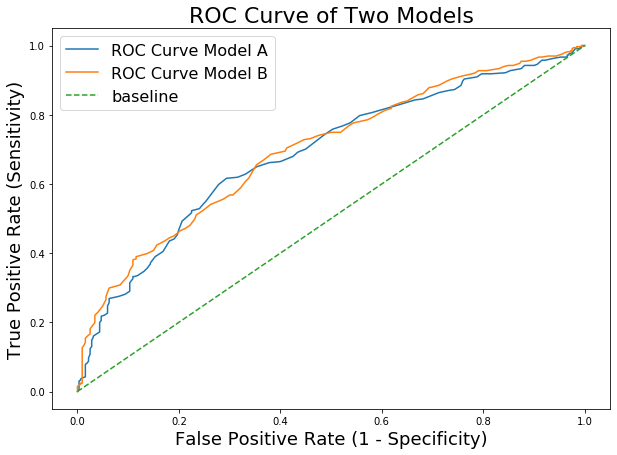

In [29]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return (true_positive / (true_positive + false_negative))
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs_a', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs_a', prob) for prob in thresholds]

tpr_values2 = [TPR(pred_df, 'true_values', 'pred_probs_b', prob) for prob in thresholds]
fpr_values2 = [FPR(pred_df, 'true_values', 'pred_probs_b', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve Model A')

plt.plot(fpr_values2, # False Positive Rate on X-axis
         tpr_values2, # True Positive Rate on Y-axis
         label='ROC Curve Model B')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title("ROC Curve of Two Models", fontsize=22)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=18)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [30]:
# Calculate AUC of both Models

auc_a = roc_auc_score(y_test, pipe_a.predict(X_test))
auc_b = roc_auc_score(y_test, pipe_b.predict(X_test))

print(f"Model A AUC is {round(auc_a, 3)}")
print(f"Model B AUC is {round(auc_b, 3)}")

Model A AUC is 0.649
Model B AUC is 0.644


Ideally, the higher the curve is to the top left of the graph, the better the performance. Visually, it is difficult to tell which model is better as the curves are very similar. Hence, we should look at the actual scores to determine which model performed better.

**Model A** performed slightly better than Model B with an AUC score of 0.649. 

In Conclusion, based on both metrics, the Confusion matrix and ROC AUC Score, **Model A** is the best model for this project.

## 5. Conclusion and Recommendations

I have managed to build a classifier model based on redditors' sentiments and opinions which could determine whether a post belong to r/godtiersuperpowers or r/shittysuperpowers. The model has a 65% accuracy in correctly determining whether a post belongs to whichever subreddit.

Another way to interpret the accuracy is that the model is able to determine whether reddit users would think a super power is "god-tier" or "shitty", with 65% chance of being right.

For example, we could test this below.

In [31]:
# determine your superpower
st = "teleport randomly"

# using Model A to predict
pred = pipe_a.predict([st])

if pred[0] == 1:
    print("Redditors think your super power is God-Tier!")
else:
    print("Redditors think your super power is Shitty!")

Redditors think your super power is Shitty!


In [32]:
# determine your superpower
st = "read while sleep"
pred = pipe_a.predict([st])

# using Model A to predict
if pred[0] == 1:
    print("Redditors think your super power is God-Tier!")
else:
    print("Redditors think your super power is Shitty!")

Redditors think your super power is God-Tier!


Seems like the model is quite successful in classifying the above statements!

Overall, the model is quite good at classifying more than half the time but it is still lacking in order for it to be more useful. 


**Limitations**

The model is far from perfect and has a lot of shortcomings and limitations. Based on EDA, preprocessing and modelling, here are three limitations which could be addressed.

1. The model is limited to the vocabularies it is trained with. It will be difficult for the model to predict from complex strings. The model uses key vocabularies from each post to train and determine the results, using vocabularies outside of the model may not work very well.


2. The topics of both subreddits are highly subjective. Even human beings have difficulty in determining what is absolute good or bad. A super power which might seem bad could be good in another's eyes. Hence, it can be very difficult to achieve high accuracy in these two subreddits.


3. It cannot process Non-ASCII Characters. The model is not able to fully analyse non-ASCII characters, such as emojis and foreign characters. They are removed but they are also data observations too. For example, emojis like 🙃 could tell us someone is being sarcastic. Unfortunately, the tools to clean and analyse non-ASCII characters are not available yet. Manually imputing is an option but it would take too long to go through everything.

**Recommendations**

1. Scrape more data and train the model with more words! As the machine learns more vocabularies, it would predict better.


2. To reduce the subjectivity and improve objectivity, perhaps more feature engineering is required. Perhaps words can be further classified into categories first. For example, they can be classified into verbs and adjectives. The current model classifies based on a mixture of verbs, adjectives and nouns.


3. Explore libraries or other tools which can analyse emojis, such as [DeepMoji](https://deepmoji.mit.edu/). This will become inevitable as more people express themselves this way, especially in cooler subreddits.

**Stakeholders**

From the EDA and model, content creators definitely could understand the kind of abilities which interest our redditors, and understand what sets both subreddits apart through analysing the words used. They can also get a sense of what redditors would think by running super powers through the model. 

For moderators, it is possible that such a model could be automated and integrated into the backend which allows for automated sorting of reddit posts. It could also be expanded to flag inappropriate content, such as racists remarks or words which violate community standards. 

However, for it to be truly feasible and applicable, the model needs to overcome the above limitations and improve its accuracy.